In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer

import re
import string
import nltk
from nltk.corpus import stopwords


import os
import shutil

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import export_text
from sklearn.inspection import permutation_importance

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import utils

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

2022-12-16 17:10:25.065969: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# for plotting graphs and visualization
from plotly.offline import iplot
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
from wordcloud import WordCloud

In [3]:
df=pd.read_csv("FakeNewsNet.csv")

In [4]:
df.head()

,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


In [25]:
df[df["real"]==0].title.iloc[9]

'ladies crush angelina jolie'

The columns:

- `title`: title of news
- `news_url`: news webpage url
- `source_domain`: domain
- `real`: (0) real (1) fake

## General EDA

### Missing values
Checking if there are missing values in the data. 

In [5]:
df.isnull().sum()

title              0
news_url         330
source_domain    330
tweet_num          0
real               0
dtype: int64

In [6]:
# dropping the missing values
df.dropna(axis=0, how='any', inplace=True)

In [7]:
temp = df.groupby('real').count()['title'].reset_index().sort_values(by='title',ascending=False)
print(temp)

   real  title
1     1  17371
0     0   5495


In [8]:
print(f"News real: \n{(df['real'].value_counts(normalize=True)) * 100}")


News real: 
1    75.968687
0    24.031313
Name: real, dtype: float64


In [13]:
df['real'].value_counts(normalize=True).iplot(kind='bar',
                                                      yTitle='Percentage', 
                                                      linecolor='black', 
                                                      opacity=0.7,
                                                      color='blue',
                                                      theme='pearl',
                                                      bargap=0.7,
                                                      gridcolor='white',
                                                     
                                                      title='Distribution of Sentiment column in the training set')

# Text Data Processing 

We will pre-process our data to make it into consistent format. 

- Make texts lowercase
- Remove hyperlinks and punctuations
- Remover numbers
- Tokenizes
- Remove stopwords

In [9]:
def clean_text(text):
    """
    Removes:
        - Texts in square brackets
        - Links
        - Punctuations
        - Words containing numbers

    Makes texts lowercase
    """
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [10]:
def text_preprocessing(text):
    """
    - Tokenizes
    - Remove stopwords 
    - Clean text
    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    no_punctuation = clean_text(text)
    
    tokenized_text = tokenizer.tokenize(no_punctuation)
    remove_stopwords = [word for word in tokenized_text if word not in stopwords.words('english')]
    combined_text = ' '.join(remove_stopwords)
    
    return combined_text

In [11]:
df['title'] = df['title'].apply(str).apply(lambda x : text_preprocessing(x))

df.head()

,title,news_url,source_domain,tweet_num,real
0,kandi burruss explodes rape accusation real ho...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,peoples choice awards best red carpet looks,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,sophia bush sends sweet birthday message one t...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,colombian singer maluma sparks rumours inappro...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,gossip girl years later upper east siders shoc...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


# Text Statistics
We will analyze our texts:
- Text length analysis
- Word frequency analysis

Adding `text_length` and `text_word_count` columns for our analysis

In [19]:
df['text_length'] = df['text'].astype(str).apply(len) # counts the spaces as well
df['text_word_count'] = df['text'].apply(lambda x : len(str(x).split()))

In [22]:
# 3 different dataframes for our news
real = df[df['real'] == 1]
fake = df[df['real'] == 0]


## Sentence length analysis

The histogram shows that the length of the cleaned text ranges from around 2 to 140 characters and generally,it is almost same for all the polarities.

In [24]:
real['text_length'].iplot(
    kind='hist',
    bins=100,
    xTitle='text length',
    linecolor='black',
    color='green',
    yTitle='count',
    title='Real News Length Distribution')

fake['text_length'].iplot(
    kind='hist',
    bins=100,
    xTitle='text length',
    linecolor='black',
    color='red',
    yTitle='count',
    title='Fake News Length Distribution')

Relationship of text length with the sentiment

In [26]:
trace0 = go.Box(
    y=real['text_length'],
    name = 'Real News',
    marker = dict(
        color = 'green',
    )
)

trace1 = go.Box(
    y=fake['text_length'],
    name = 'Fake News',
    marker = dict(
        color = 'red',
    )
)


data = [trace0, trace1]
layout = go.Layout(
    title = "Length of the text"
)

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "Length of the text of different polarities")


# Ngram exploration


N-grams are used to describe the number of words used as observation points
- unigram means singly-worded
- bigram means 2-worded phrase
- trigram means 3-worded phrase

![N-gram](https://i.stack.imgur.com/8ARA1.png)

In [27]:
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [29]:
## top unigram 
realnews_unigrams = get_top_n_words(real['title'], 20)
realnews_unigrams

[('new', 823),
 ('season', 621),
 ('kardashian', 620),
 ('awards', 592),
 ('says', 502),
 ('star', 502),
 ('wedding', 492),
 ('baby', 466),
 ('kim', 426),
 ('reveals', 413),
 ('best', 400),
 ('prince', 389),
 ('watch', 376),
 ('meghan', 359),
 ('jenner', 339),
 ('video', 338),
 ('stars', 332),
 ('jennifer', 317),
 ('tv', 311),
 ('taylor', 285)]

In [30]:
fakenews_unigrams = get_top_n_words(fake['text'], 20)

In [32]:
df1 = pd.DataFrame(realnews_unigrams, columns = ['title' , 'count'])
df1.groupby('title').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black',color='green', title='Top 20 Unigrams in positve text',orientation='h')

In [33]:
df1 = pd.DataFrame(fakenews_unigrams, columns = ['title' , 'count'])
df1.groupby('title').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black',color='red', title='Top 20 Unigrams in negative text',orientation='h')

In [34]:
realnews_text = df[df['real'] == 1]['title']
fakenews_text = df[df['real'] == 0]['title']


# pre-processed selected text column
realnews_text_clean = realnews_text.apply(lambda x: text_preprocessing(x))
fakenews_text_clean = fakenews_text.apply(lambda x: text_preprocessing(x))


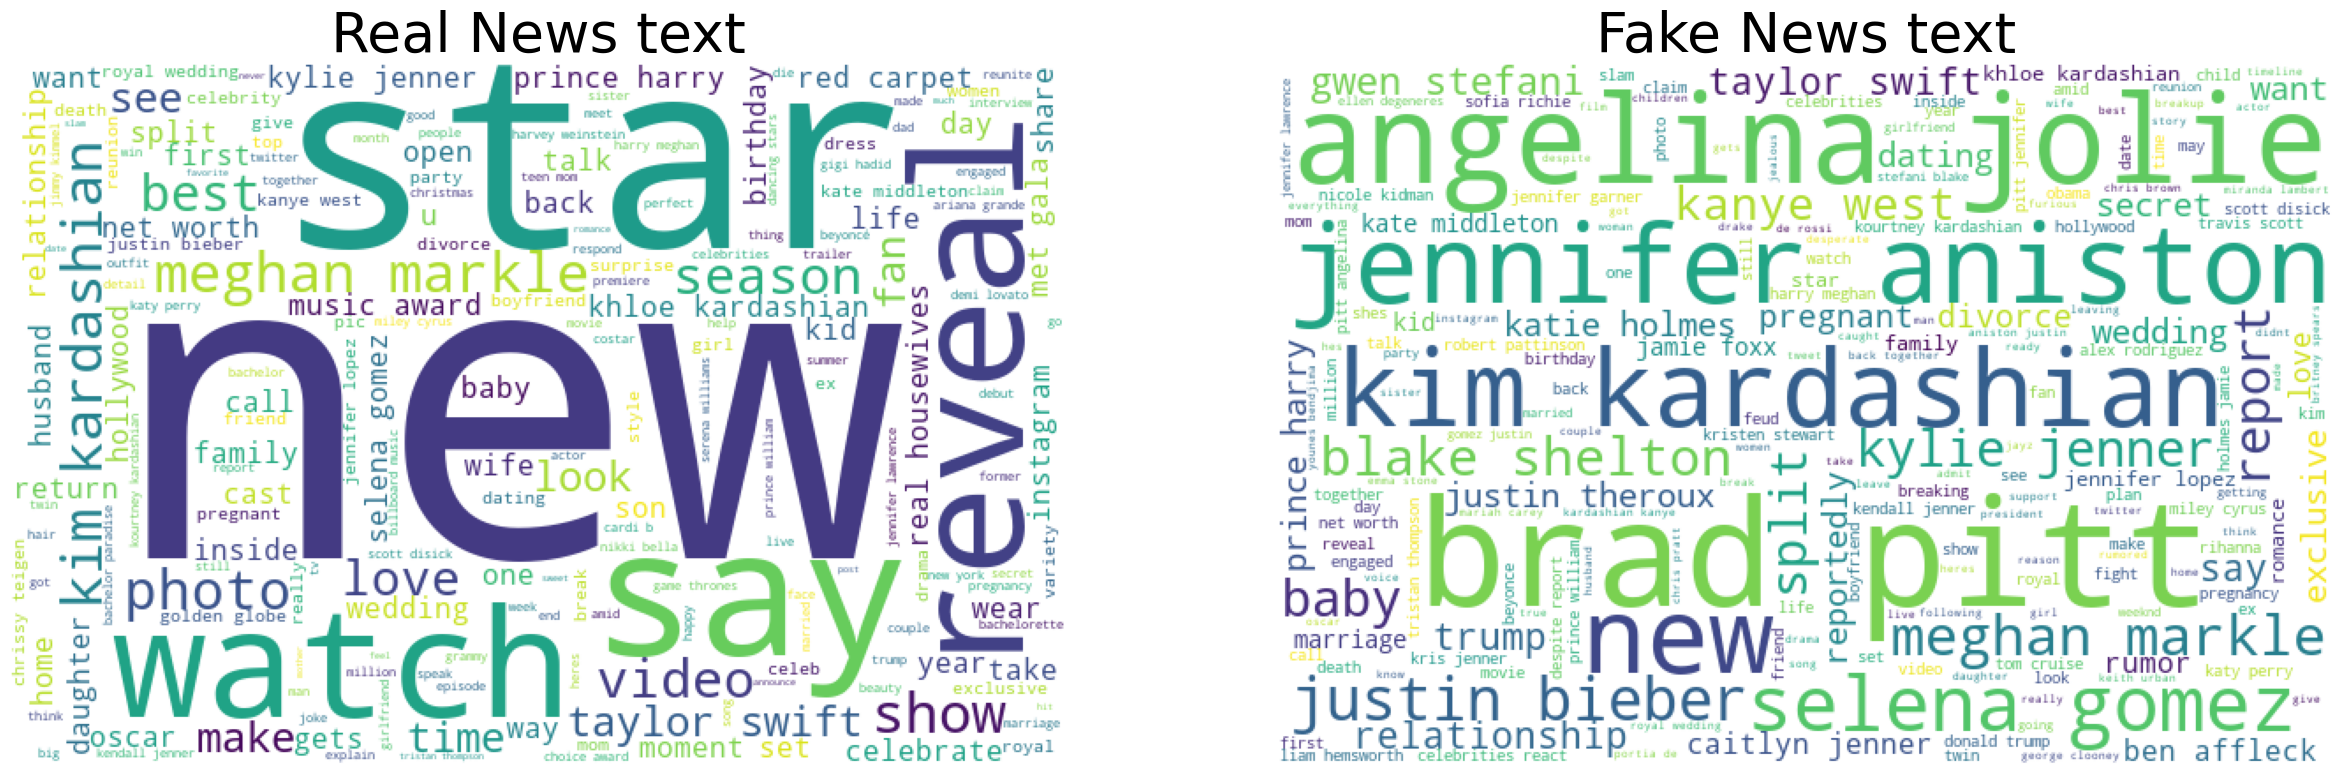

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[30, 15])

wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(realnews_text_clean))

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Real News text',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(fakenews_text_clean))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Fake News text',fontsize=40);



### Feature important 
we have only one feature out here so computation of feature importants does not make much sence. 

In [37]:
df.real.value_counts()

1    17371
0     5495
Name: real, dtype: int64

In [12]:
X = pd.DataFrame(df, columns=['title'])
y = df.real
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [13]:
df.head()

,title,news_url,source_domain,tweet_num,real
0,kandi burruss explodes rape accusation real ho...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,peoples choice awards best red carpet looks,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,sophia bush sends sweet birthday message one t...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,colombian singer maluma sparks rumours inappro...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,gossip girl years later upper east siders shoc...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


####  Model selection 
Going with default hyparameter setting. list of training algorithm
-   logistic regresssion
-   Decision Tree
-   Random Forest
-   CNN model


In [14]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train.title.values)
X_test = vectorizer.transform(X_test.title.values)

In [43]:
## logistic regresssion
classifier = LogisticRegression(multi_class='multinomial',class_weight='balanced', solver='lbfgs',max_iter=200)
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.8132925229558373


In [44]:
## Decision Tree
classifier = DecisionTreeClassifier(class_weight='balanced')
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.7822474857892435


In [45]:
## Random Forest
classifier = RandomForestClassifier(class_weight='balanced')
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.8272846523830345


In [11]:
## CNN model
X = pd.DataFrame(df, columns=['title'])
y = df.real
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train.title.values)

X_train = tokenizer.texts_to_sequences(X_train.title.values)
X_test = tokenizer.texts_to_sequences(X_test.title.values)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index


In [12]:
from keras.utils import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [13]:

y_train = utils.to_categorical(y_train, 2)
y_test = utils.to_categorical(y_test, 2)

In [14]:
embedding_dim = 100

model = models.Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(2, activation="sigmoid"))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1771000   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                                 
Total params: 1,836,440
Trainable params: 1,836,440
Non-trainable params: 0
______________________________________________

2022-12-16 17:02:19.787378: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
model.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)


Epoch 1/10
2058/2058 [==============================] - 31s 15ms/step - loss: 0.4265 - accuracy: 0.8195 - val_loss: 0.3860 - val_accuracy: 0.8338
Epoch 2/10
2058/2058 [==============================] - 29s 14ms/step - loss: 0.3062 - accuracy: 0.8749 - val_loss: 0.3842 - val_accuracy: 0.8356
Epoch 3/10
2058/2058 [==============================] - 29s 14ms/step - loss: 0.2052 - accuracy: 0.9189 - val_loss: 0.4829 - val_accuracy: 0.8360
Epoch 4/10
2058/2058 [==============================] - 30s 14ms/step - loss: 0.1229 - accuracy: 0.9542 - val_loss: 0.6437 - val_accuracy: 0.8334
Epoch 5/10
2058/2058 [==============================] - 29s 14ms/step - loss: 0.0770 - accuracy: 0.9700 - val_loss: 0.7345 - val_accuracy: 0.8220
Epoch 6/10
2058/2058 [==============================] - 30s 15ms/step - loss: 0.0550 - accuracy: 0.9779 - val_loss: 0.9325 - val_accuracy: 0.8111
Epoch 7/10
2058/2058 [==============================] - 30s 15ms/step - loss: 0.0408 - accuracy: 0.9820 - val_loss: 1.0176 -

In [16]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Training Accuracy: 0.9881
Testing Accuracy:  0.8037


## Model Selection & Hyparameter tunning 
-   Algorithm              -------> Accuracy
-   Logistic regresssion   -------> 0.8132
-   Decision Tree          -------> 0.7822
-   Random Forest          -------> 0.8272
-   CNN model              -------> 0.8037

We are going to select one model out of above. i have selected randomforest for fruther hyperparameter tunning and build final model for serving with RestAPI.


In [15]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1,
                                    class_weight='balanced')
        rf.fit(X_train, y_train)

        accuracy = rf.score(X_test, y_test)

        scores.append((d, n, accuracy))

In [16]:
columns = ['max_depth', 'n_estimators', 'accuracy']
df_scores = pd.DataFrame(scores, columns=columns)

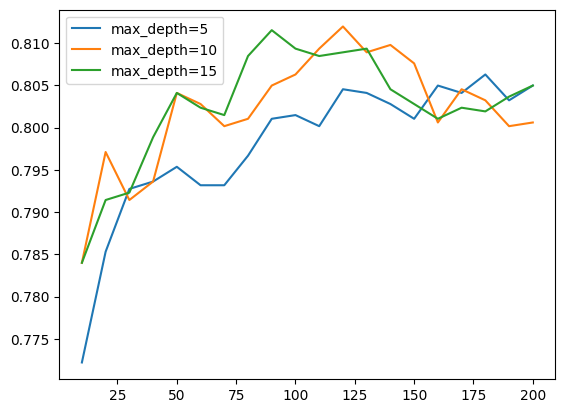

In [17]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.accuracy,
             label='max_depth=%d' % d)

plt.legend()

In [18]:
## accuracy best at max_depth == 15
max_depth = 15

In [19]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1,
                                    class_weight='balanced')
        rf.fit(X_train, y_train)
        accuracy = rf.score(X_test, y_test)
        scores.append((s, n, accuracy))

In [20]:
columns = ['min_samples_leaf', 'n_estimators', 'accuracy']
df_scores = pd.DataFrame(scores, columns=columns)

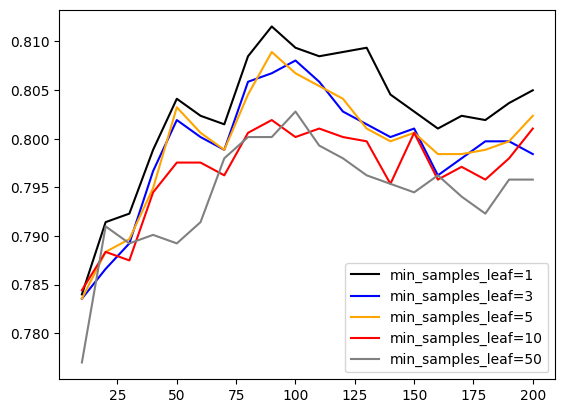

In [21]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.accuracy,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [22]:
## accuracy best at min_samples_leaf=1 with above graph
min_samples_leaf = 1

rf = RandomForestClassifier(n_estimators=110,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1,
                            class_weight='balanced')
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15, n_estimators=110,
                       random_state=1)